# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generating figure 1. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

# 1. Preprocessing hospital admission counts (statistik-covid19-inskrivna_v2.xlsx)

In [11]:

#import modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [3]:
file = pandas.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
file  #Newly admitted to inpatient care with COVID-19, number of patients per admission week and region

,"Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,Antal unika patienter som rapporterats till So...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Totalt antal inskrivna patienter,NaN,Månadsrapportering till patientregistret,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,vecka 10,NaN,vecka 11,NaN,vecka 12,NaN,vecka 13,...,vecka 48,NaN,vecka 49,NaN,vecka 50,NaN,vecka 51,NaN,vecka 52,NaN
5,NaN,Antal,%*,Antal,%**,Antal,%**,Antal,%**,Antal,...,Antal,%**,Antal,%**,Antal,%**,Antal,%**,Antal,%**
6,Totalt inrapporterat,35057,100,63,0.179707,169,0.482072,639,1.822746,1465,...,1667,4.755113,1568,4.472716,1608,4.586816,1251,3.568474,365,1.041162
7,Rapporterande region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Stockholm,13035,37.182303,37,0.283851,83,0.636747,335,2.570004,734,...,632,4.848485,548,4.204066,521,3.996931,347,2.662064,43,0.329881
9,Västra Götaland,5293,15.098269,9,0.170036,18,0.340072,56,1.058001,94,...,205,3.87304,259,4.893255,323,6.102399,328,6.196864,202,3.816361


## 1.1. Taking VGR region and replacing missing value with 0

In [4]:
data = [['Sthlm', 8], ['VGR', 9], ['Skåne', 10],['Östergötland',11],['Jönköping',12],['Södermanland',13],['Uppsala',14],['Gävelborg',15],['Västmanland',16],['Örebro',17],['Norrbotten',18],['Dalarna',19],['Västernorrland',20],['Värmland',21],['Halland',22],['Kalmar',23],['Kronoberg',24],['Västerbotten',25],['Jämtland',26],['Blekinge',27],['Gotland',28]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index']) 
vald_region='VGR'
temp=regioner.loc[regioner['region']==vald_region] #find the VGR-data
index=temp['index'].values 
R = file.iloc[index[0]]
R=R.replace(' ','X') #replace missing data with 0
R=R.replace('X',0)
R

Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region    Västra Götaland
Unnamed: 1                                                                                            5293
Unnamed: 2                                                                                       15.098269
Unnamed: 3                                                                                               9
Unnamed: 4                                                                                        0.170036
                                                                                                ...       
Unnamed: 84                                                                                       6.102399
Unnamed: 85                                                                                            328
Unnamed: 86                                                                                       6.196864
Unnamed: 87                          

## 1.2 Creating array or vector I having count details for total  44 weeks 

In [5]:
ind = np.arange(3,len(R),2) #find admissions
ind

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87])

In [14]:
len(ind)

43

In [6]:
I = R.iloc[ind].values 
I

array([9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205, 210, 183,
       150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19, 25, 16, 24,
       24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323, 328, 202],
      dtype=object)

#### 1.2.1 Adding four weeks with no cases

In [7]:
I=np.insert(I,0,[0,0,0,0]) #add four weeks with no cases
I

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323, 328,
       202], dtype=object)

#### 1.2.2 Removing last weeks count data

In [8]:
I=I[:-2] #remove last data point
I

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323],
      dtype=object)

#### 1.2.3 Creating vectors containing week numbers

In [9]:
veckor = np.arange(0,len(I),1) #define week numbers
veckor

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

# 2. Defining parameters

In [3]:
#Parameters
startvecka=10-4 #first week with case data minus the padding
Tmax=53 #length of prediction
N=1725881 #population of VGR
pv=0.023 #fraction of cases that are admitted

rho=7*1/5.1 #incubation rate
gamma=7*1/5 #recovery rate

delay=3 #time from infection to admission

In [4]:
#Load data from Västtrafik
df = pandas.read_excel('../data/VT.xlsx') 
values = df['Unnamed: 4'].values
diff = np.array(values[4:])
diff = np.insert(diff,0,[0.2,0.2])#baseline travel
T = np.arange(7,7+len(diff),1) 

In [12]:
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function

In [6]:
#time-dependent infectivity
def beta(t,a,b):
    return a+b*resfkn(t)

In [13]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b)*x3/N
    dx2 = x1*beta(t-lag,a,b)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    
    return [dx1, dx2, dx3, dx4]

In [14]:
#define the model output
def pred_inlagda(t,a,b,lag):
    #intialvillkor
    x0 = [N-1,0,1,0] #initial conditions
    x = odeint(dx, x0, t,args=(a,b,lag))
    return pv*x[:,2]

In [15]:
#performing global grid search
#For better parameter estimates this can be rerun with higher value of n around the expected optimum
I_train=I
veckor_train=veckor
n=10
ah=np.linspace(3,5,n)
bh=np.linspace(4,6,n)

E=np.zeros((len(ah),len(bh)))
for i in range(n):
    print(i)
    for j in range(n):
        P=pred_inlagda(veckor_train,ah[i],bh[j],delay)
        E[i,j]=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))

0
1
2
3
4
5
6
7
8
9


In [10]:
#Extract parameters with smallest error
optind = np.where(E == np.amin(E))
afit = ah[optind[0]]
bfit = bh[optind[1]]

print("Minimum RMSE: ",E[optind])
print("a=",afit,"b=",bfit)

Minimum RMSE:  [52.76745708]
a= [4.11111111] b= [5.77777778]


In [11]:
#performing local search
I_train=I
veckor_train=veckor
fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit[0],bfit[0],3))

In [12]:
P=pred_inlagda(veckor_train,fit[0],fit[1],delay)
E=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))
print("Model error (RMSE)=",E,"admissions/week")

Model error (RMSE)= 40.8328603504589 admissions/week


In [13]:
#Genererate confidence intervals
M=100
t=np.linspace(0,Tmax-startvecka,200)
P=np.zeros((M,int(len(t))))
perr = np.sqrt(np.diag(cov))
for i in range(M):
    a_r = np.random.normal(fit[0],perr[0],1)[0]
    b_r = np.random.normal(fit[1],perr[1],1)[0]
    print(a_r)
    P[i,:]=pred_inlagda(t,a_r,b_r,delay)
Pu=np.percentile(P,97.5,axis=0)
Pl=np.percentile(P,2.5,axis=0)

4.117620127705054
4.141988005919946
4.121250463708119
4.106202239489399
4.113684922625341
4.124025284120154
4.116756294603349
4.132201917054741
4.133274093415056
4.147210274618131
4.091472513128147
4.123887794879113
4.157489644693397
4.1503313132459665
4.123803801025691
4.2022282282997026
4.075798640381793
4.146665302894786
4.11988447882645
4.136557941950866
4.1775675336589995
4.150214880869415
4.1768533456524155
4.155782326920976
4.152667272229116
4.138858191110158
4.0249788219008
4.125021420958466
4.125166479726144
4.146663206484784
4.145545242723033
4.116757608122632
4.134249615776623
4.149173985255156
4.092685060393066
4.100104244384924
4.089185355604597
4.0892589990888135
4.176370405346263
4.116077522887653
4.1441247846347276
4.144678973529984
4.141948266127379
4.071968672795577
4.170740145323841
4.09515195250925
4.108525064222702
4.1493023665648225
4.162442367338071
4.132444293128309
4.112152517653891
4.174500454659127
4.174285559851692
4.161931542941154
4.127285486142596
4.10704

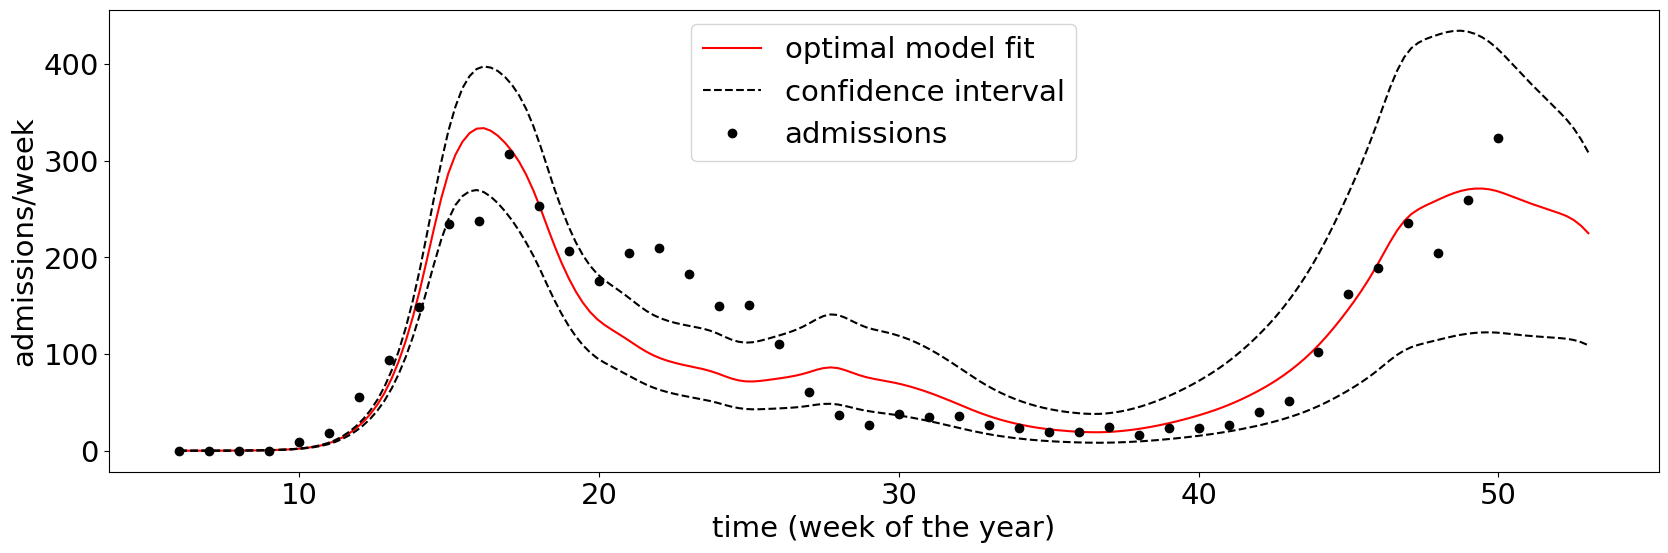

In [14]:
#plot the results
t=np.linspace(0,Tmax-startvecka,200)
fig, axes = plt.subplots(1,1,figsize=(20,6))
pred = pred_inlagda(t,fit[0],fit[1],delay)

axes.plot(t+startvecka,pred,'r',label="optimal model fit")
axes.plot(t+startvecka,Pu,'k--',label="confidence interval")
axes.plot(t+startvecka,Pl,'k--')

axes.plot(veckor+startvecka,I,'ko',label="admissions")

axes.set_xlabel('time (week of the year)')
axes.set_ylabel('admissions/week')
axes.legend()

In [15]:
#save output
tp=np.arange(0,Tmax-startvecka,1)
pred = pred_inlagda(tp,fit[0],fit[1],delay)

np.savetxt('tid.csv',tp+startvecka, delimiter=',')
np.savetxt('inlagda.csv',np.round(pred), delimiter=',')

In [16]:
#calculate model fit when amount of training data is varied
A=np.array([])
B=np.array([])
RMSE=np.array([])
MAPE=np.array([])

hor=3
tt=np.arange(20-startvecka,len(I)-hor,1)
for k in tt:
    I_train=I[0:k]
    veckor_train=veckor[0:k]
    I_test=I[0:k+hor]
    veckor_test=veckor[0:k+hor]
    
    fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit[0],bfit[0],3))
    
    A=np.append(A,fit[0])
    B=np.append(B,fit[1])
    Pp=pred_inlagda(veckor,fit[0],fit[1],delay)
    ep=np.sqrt(np.sum((Pp[k:k+hor]-I[k:k+hor])**2)/hor)
    mp=np.sum(np.abs(Pp[k:k+hor]-I[k:k+hor])/I[k:k+hor])/hor
        
    RMSE=np.append(RMSE,ep)
    MAPE=np.append(MAPE,mp)
    
    print("k=",k,"a=",A[-1],"b=",B[-1])
    


k= 14 a= 4.111111132408931 b= 5.777777788819289
k= 15 a= 4.078860515378588 b= 5.329897804566196
k= 16 a= 4.070783315167408 b= 5.190730057299063
k= 17 a= 4.081958011976204 b= 5.209632561782064
k= 18 a= 4.0687543180103845 b= 5.128059091876735
k= 19 a= 4.071659028233847 b= 5.161987070595979
k= 20 a= 4.086810223039971 b= 5.243886208744094
k= 21 a= 4.076250455404319 b= 5.230527151406086
k= 22 a= 4.090988888903764 b= 5.3572909439541005
k= 23 a= 4.105030829517085 b= 5.481357477406362
k= 24 a= 4.098911131589143 b= 5.495487615689448
k= 25 a= 4.103226508213437 b= 5.538499405154862
k= 26 a= 4.104099707417364 b= 5.556192569404986
k= 27 a= 4.115812216832887 b= 5.622486855702445
k= 28 a= 4.0726756656132 b= 5.46252042569875
k= 29 a= 4.097677505330279 b= 5.542931123317416
k= 30 a= 4.1047364462489595 b= 5.574710665253158
k= 31 a= 4.125754376547265 b= 5.659733827660504
k= 32 a= 4.130114471266479 b= 5.670298807672213
k= 33 a= 4.100665329913386 b= 5.5626713974256115
k= 34 a= 4.108191391336394 b= 5.5885088

<unknown>:15: SyntaxWarning: invalid escape sequence '\w'
<unknown>:16: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:16: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:16: SyntaxWarning: invalid escape sequence '\w'
<ipython-input-17-68797db22bb4>:15: SyntaxWarning: invalid escape sequence '\w'
  axes[1].plot(tt+0*startvecka,A,'b',label="$\widehat{a}$")
<ipython-input-17-68797db22bb4>:16: SyntaxWarning: invalid escape sequence '\w'
  axes[1].plot(tt+0*startvecka,B,'g',label="$\widehat{b}$")


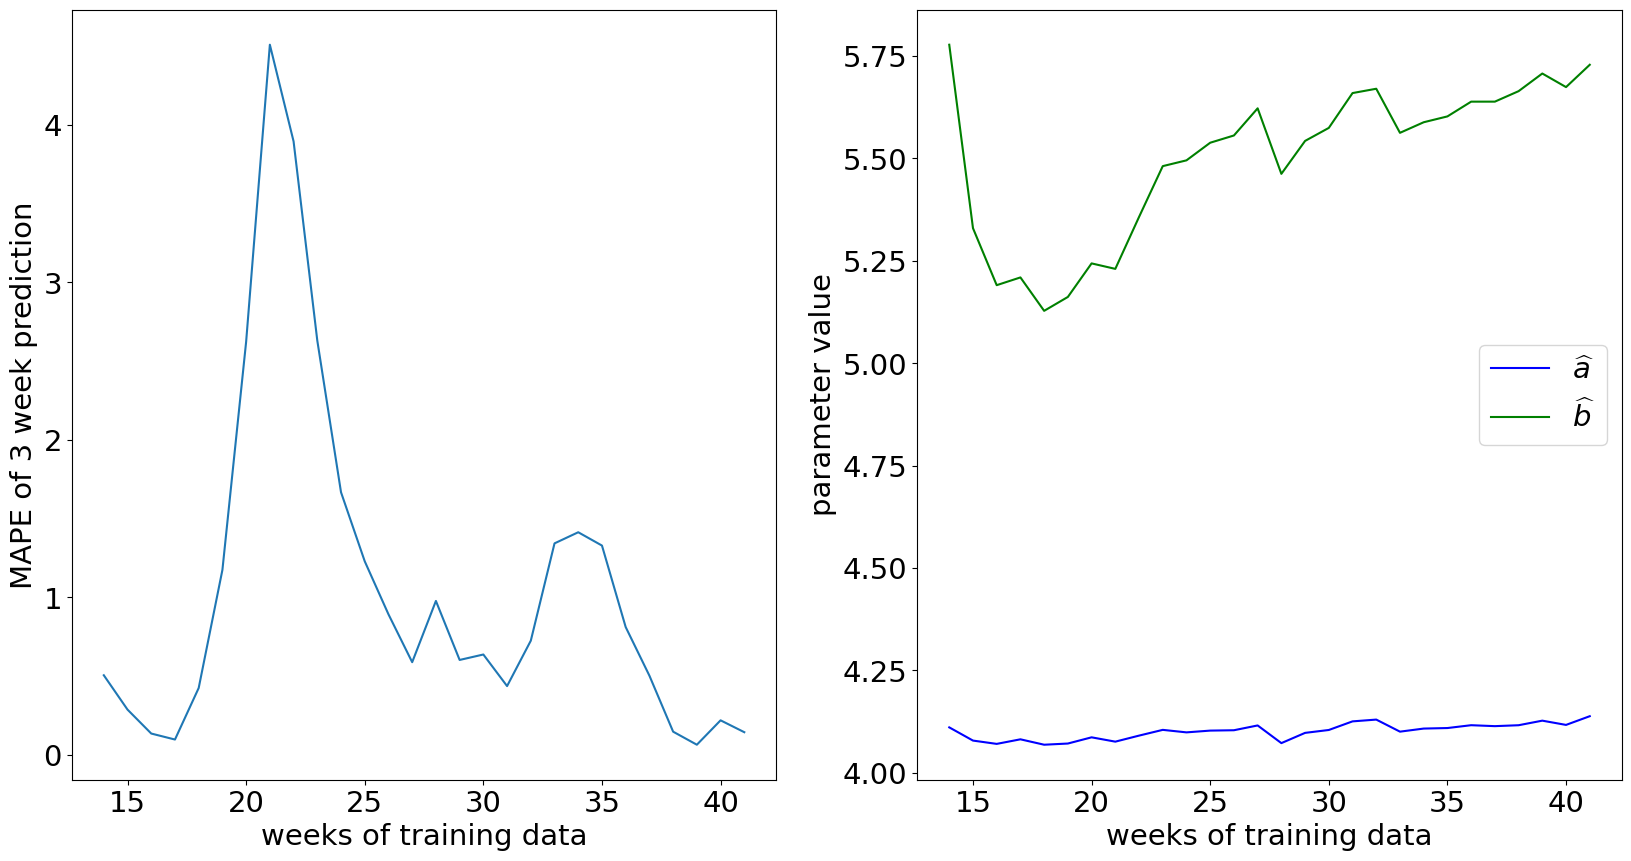

In [17]:
#plot how MAPE and parameter estimates change
t=np.linspace(0,41,100)
trans=np.linspace(0,1,len(A))
P=pred_inlagda(t,A[-1],B[-1],delay)
Pt=pred_inlagda(veckor,A[-1],B[-1],delay)


fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].plot(tt+0*startvecka,MAPE)
axes[0].set_xlabel('weeks of training data')
axes[0].set_ylabel('MAPE of 3 week prediction')


axes[1].plot(tt+0*startvecka,A,'b',label="$\widehat{a}$")
axes[1].plot(tt+0*startvecka,B,'g',label="$\widehat{b}$")
axes[1].set_xlabel('weeks of training data')
axes[1].set_ylabel('parameter value')
axes[1].legend()